In [1]:
import sqlite3
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
#import plotly.graph_objs as go
%matplotlib inline 

from matplotlib.pyplot import figure
figure(figsize=(20,20), dpi=200)

from pylab import rcParams
rcParams["figure.figsize"] = 20,20

#from plotly import __version__
#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


<Figure size 4000x4000 with 0 Axes>

In [2]:
cwd = os.getcwd()
data_base_path = os.path.join(cwd, "orlen_stock_v2.db")

In [3]:
def connect_db(path):
    db = sqlite3.connect(path)
    return db


In [4]:
con = connect_db(data_base_path)
df = pd.read_sql_query("SELECT * from pkn_stock_v2 ORDER by date ASC", con)

In [5]:
print(df.head())
con.close()


                  date  open    MIN   MAX  close     volume       trade
0  2000-02-02 00:00:00  24.9  25.10  24.6   25.0  1119386.0  55633484.0
1  2000-02-03 00:00:00  25.2  26.11  25.2   25.9  1286766.0  66023963.0
2  2000-02-04 00:00:00  26.2  26.50  25.4   25.6   990461.0  51404926.0
3  2000-02-07 00:00:00  25.5  25.70  25.1   25.3   855721.0  43470627.0
4  2000-02-08 00:00:00  25.3  25.30  24.8   25.0  1232197.0  61733070.0


In [6]:
df = df.set_index("date")
df.head()

,open,MIN,MAX,close,volume,trade
date,,,,,,
2000-02-02 00:00:00,24.9,25.10,24.6,25.0,1119386.0,55633484.0
2000-02-03 00:00:00,25.2,26.11,25.2,25.9,1286766.0,66023963.0
2000-02-04 00:00:00,26.2,26.50,25.4,25.6,990461.0,51404926.0
2000-02-07 00:00:00,25.5,25.70,25.1,25.3,855721.0,43470627.0
2000-02-08 00:00:00,25.3,25.30,24.8,25.0,1232197.0,61733070.0


In [7]:
def rsi(df, periods=14, ema=True):
    """
    Retruns Relative strengh index value
    """
    close_delta = df["close"].diff(1).dropna()
    # make 2 series - up and down
    up = close_delta.clip(lower=0)
    down = -1*close_delta.clip(upper=0)
    if ema == True:
        ma_up = up.ewm(com=periods-1, adjust=True, min_periods=periods).mean()
        ma_down = down.ewm(com=periods-1, adjust=True, min_periods=periods).mean()
    else:
        #use simple moving avg
        ma_up = up.rolling(window=periods).mean()
        ma_down = down.rolling(window=periods).mean()
        
    rsi = ma_up/ma_down
    rsi = 100 - (100/(1+rsi))
    
    return rsi

def EMA(df, period=20, column="close"):
    return df[column].ewm(span=period, adjust=False).mean()

def MACD(df, period_long=26, period_short=12, period_signal=9, column="close"):
    short_ema = EMA(df, period_short, column=column)   
    long_ema = EMA(df, period_long, column=column)
    df["MACD"] = short_ema-long_ema
    df["SIGNAL_Line"] = EMA(df, period_signal, column="MACD")
    return df

def profits(df, column_open="open", column_close="close"):
    df["profit"] = df[column_close]-df[column_open]
    df["% profit"] = df["profit"]*100/df[column_open]
    return df
 
def ATR(df, look_back=14 ,min_column="MIN", max_column="MAX", close_column="close"):
    high_low = df[max_column] - df[min_column]
    high_close = np.abs(df[max_column] - df[close_column].shift())
    low_close = np.abs(df[min_column] - df[close_column].shift())
    ranges = pd.concat([high_low, high_close, low_close], axis=1)
    true_range = np.max(ranges, axis=1)
    df["ATR"] = true_range.rolling(look_back).sum()/look_back
    return df


def get_adx(df, look_back, min_column="MIN", max_column="MAX", close_column="close"):
    plus = df[max_column].diff().clip(lower=0)
    minus = df[min_column].diff().clip(upper=0)
    tr1 = pd.DataFrame(df[max_column]-df[min_column])
    tr2 = pd.DataFrame(abs(df[max_column]-df[close_column].shift(1)))
    tr3 = pd.DataFrame(abs(df[min_column]-df[close_column].shift(1)))
    frames=[tr1, tr2, tr3]
    join_tr = pd.concat(frames, axis=1, join="inner").max(axis=1)
    atr = join_tr.rolling(look_back).mean()
    
    plus_di = 100*(plus.ewm(alpha=1/look_back).mean()/atr)
    minus_di = abs(100*(minus.ewm(alpha=1/look_back).mean()/atr))
    dx = (abs(plus_di-minus_di)/abs(plus_di+minus_di))*100
    adx=((dx.shift(1)*(look_back-1))+dx)/look_back
    adx_smooth = adx.ewm(alpha=1/look_back).mean()
    
    df["plus_di"], df["minus_di"], df["adx_smooth"] = plus_di, minus_di, adx_smooth
    
    return df
         

In [8]:
rolling_means = [5,10,20,100,200]
for i in rolling_means:
    df.loc[:, "ma"+str(i)] = df.close.rolling(i).mean()

df.head()


,open,MIN,MAX,close,volume,trade,ma5,ma10,ma20,ma100,ma200
date,,,,,,,,,,,
2000-02-02 00:00:00,24.9,25.10,24.6,25.0,1119386.0,55633484.0,NaN,NaN,NaN,NaN,NaN
2000-02-03 00:00:00,25.2,26.11,25.2,25.9,1286766.0,66023963.0,NaN,NaN,NaN,NaN,NaN
2000-02-04 00:00:00,26.2,26.50,25.4,25.6,990461.0,51404926.0,NaN,NaN,NaN,NaN,NaN
2000-02-07 00:00:00,25.5,25.70,25.1,25.3,855721.0,43470627.0,NaN,NaN,NaN,NaN,NaN
2000-02-08 00:00:00,25.3,25.30,24.8,25.0,1232197.0,61733070.0,25.36,NaN,NaN,NaN,NaN


df = MACD(df)

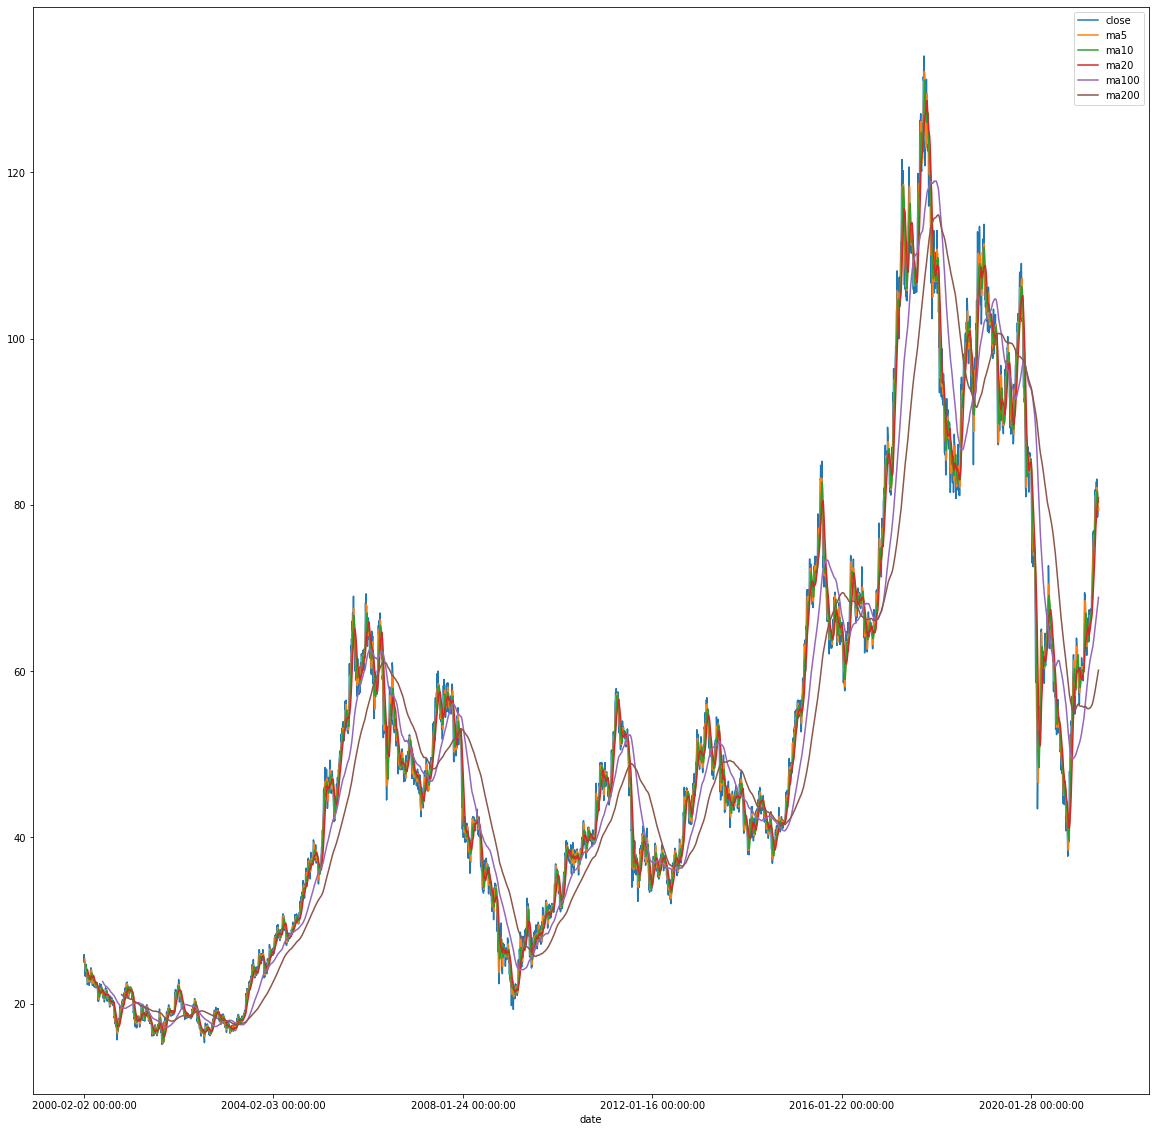

In [9]:
df[["close", "ma5", "ma10", "ma20", "ma100", "ma200"]].plot()

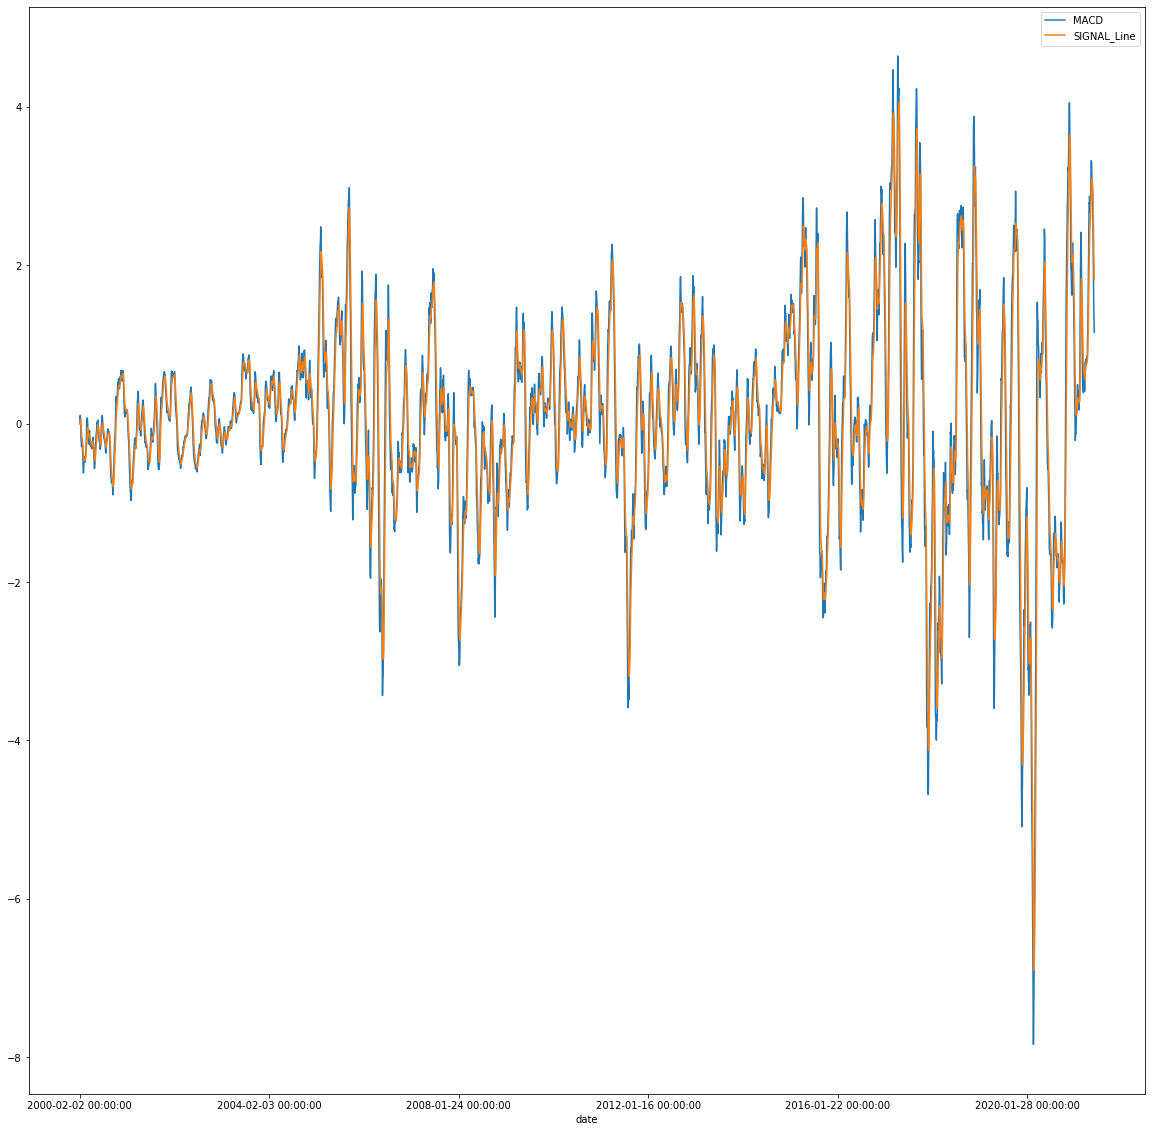

In [10]:
df = MACD(df)
df[["MACD", "SIGNAL_Line"]].plot()

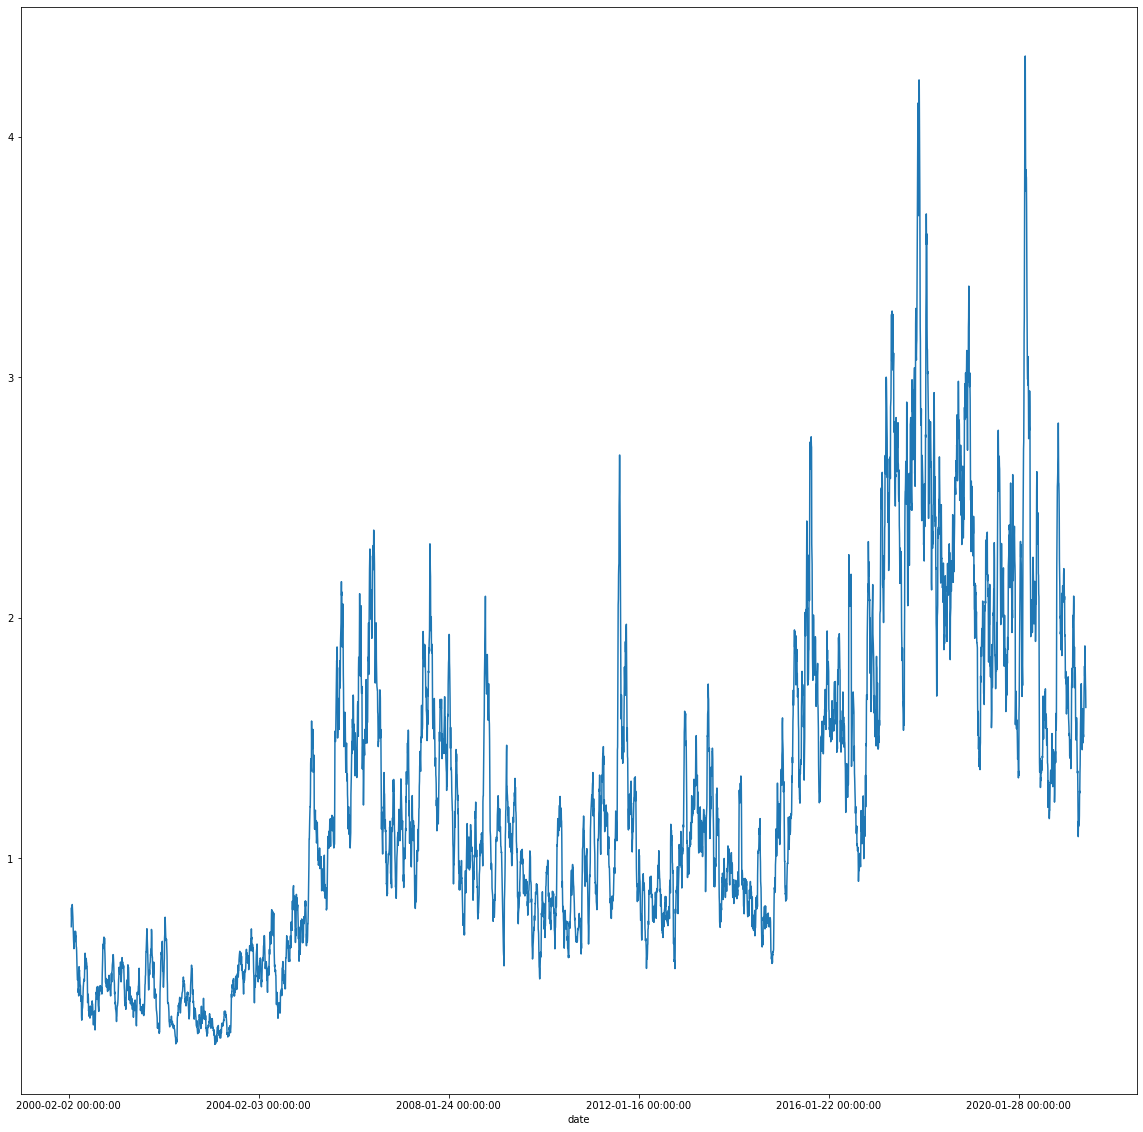

In [11]:
df = ATR(df)
df["ATR"].plot()

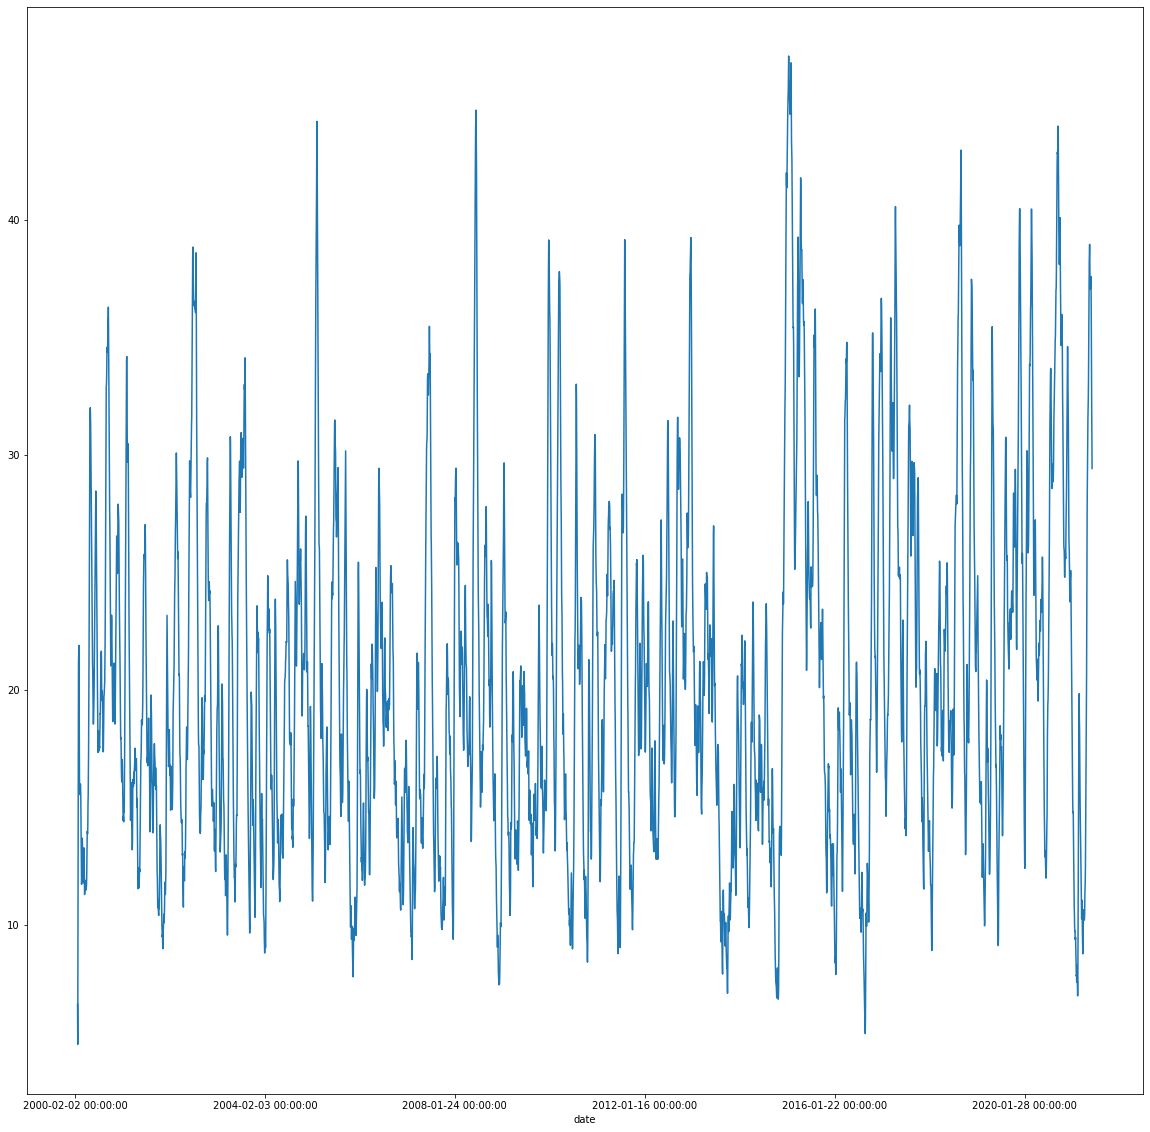

In [12]:
df = get_adx(df, look_back=14)
df["adx_smooth"].plot()

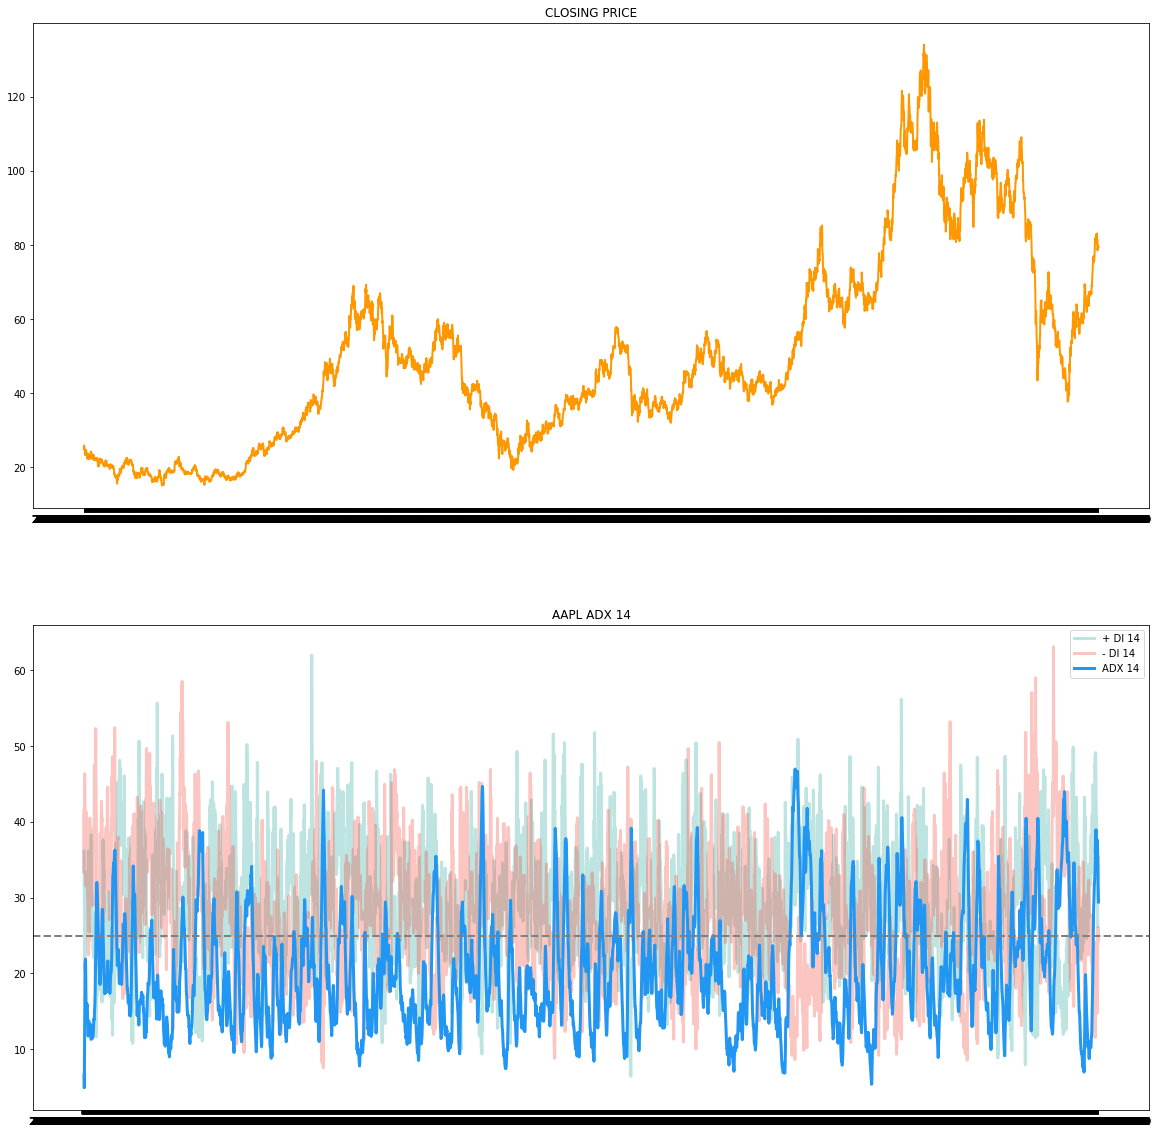

In [13]:
ax1 = plt.subplot2grid((11,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((11,1), (6,0), rowspan = 5, colspan = 1)
ax1.plot(df['close'], linewidth = 2, color = '#ff9800')
ax1.set_title('CLOSING PRICE')
ax2.plot(df['plus_di'], color = '#26a69a', label = '+ DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(df['minus_di'], color = '#f44336', label = '- DI 14', linewidth = 3, alpha = 0.3)
ax2.plot(df['adx_smooth'], color = '#2196f3', label = 'ADX 14', linewidth = 3)
ax2.axhline(25, color = 'grey', linewidth = 2, linestyle = '--')
ax2.legend()
ax2.set_title('AAPL ADX 14')
plt.show()

In [14]:

df = profits(df)
df.head(50)

,open,MIN,MAX,close,volume,trade,ma5,ma10,ma20,ma100,ma200,MACD,SIGNAL_Line,ATR,plus_di,minus_di,adx_smooth,profit,% profit
date,,,,,,,,,,,,,,,,,,,
2000-02-02 00:00:00,24.90,25.10,24.60,25.00,1119386.0,55633484.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.10,0.401606
2000-02-03 00:00:00,25.20,26.11,25.20,25.90,1286766.0,66023963.0,NaN,NaN,NaN,NaN,NaN,0.071795,0.014359,NaN,NaN,NaN,NaN,0.70,2.777778
2000-02-04 00:00:00,26.20,26.50,25.40,25.60,990461.0,51404926.0,NaN,NaN,NaN,NaN,NaN,0.103295,0.032146,NaN,NaN,NaN,NaN,-0.60,-2.290076
2000-02-07 00:00:00,25.50,25.70,25.10,25.30,855721.0,43470627.0,NaN,NaN,NaN,NaN,NaN,0.102865,0.046290,NaN,NaN,NaN,NaN,-0.20,-0.784314
2000-02-08 00:00:00,25.30,25.30,24.80,25.00,1232197.0,61733070.0,25.360,NaN,NaN,NaN,NaN,0.077425,0.052517,NaN,NaN,NaN,NaN,-0.30,-1.185771
2000-02-09 00:00:00,25.20,25.30,24.40,24.50,2136237.0,106170979.0,25.260,NaN,NaN,NaN,NaN,0.016724,0.045358,NaN,NaN,NaN,NaN,-0.70,-2.777778
2000-02-10 00:00:00,24.40,24.50,24.00,24.31,980685.0,47563223.0,24.942,NaN,NaN,NaN,NaN,-0.046180,0.027051,NaN,NaN,NaN,NaN,-0.09,-0.368852
2000-02-11 00:00:00,24.00,24.00,23.10,23.30,2368369.0,111550180.0,24.482,NaN,NaN,NaN,NaN,-0.175508,-0.013461,NaN,NaN,NaN,NaN,-0.70,-2.916667
2000-02-14 00:00:00,22.80,24.20,22.80,24.00,1776213.0,83482011.0,24.222,NaN,NaN,NaN,NaN,-0.218992,-0.054567,NaN,NaN,NaN,NaN,1.20,5.263158


/home/mateusz/anaconda3/envs/new_env_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  after removing the cwd from sys.path.
/home/mateusz/anaconda3/envs/new_env_gpu/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  # This is added back by InteractiveShellApp.init_path()


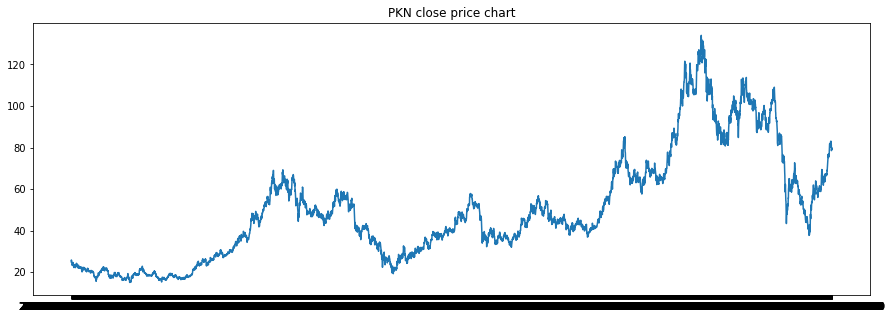

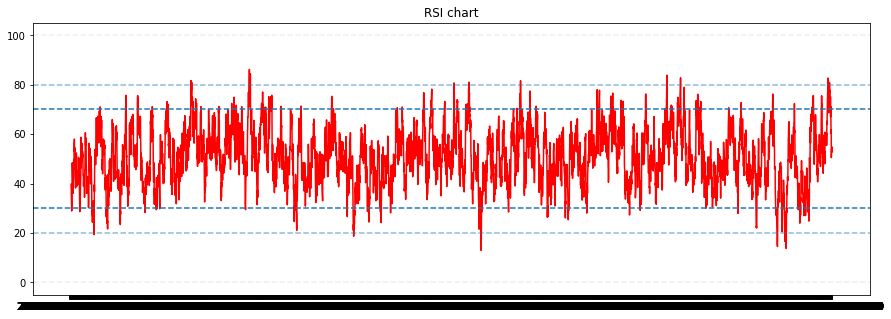

In [15]:
df["rsi"] = rsi(df)
plt.figure(figsize=(15,5))
plt.plot(df.index, df["close"])
plt.locator_params(axis="x", nbins=10)
plt.title("PKN close price chart")

plt.figure(figsize=(15,5))
plt.title("RSI chart")

plt.plot(df.index, df["rsi"], c="r")
plt.locator_params(axis="x", nbins=10)
plt.axhline(0, linestyle="--", alpha=0.1)
plt.axhline(20, linestyle="--", alpha=0.5)
plt.axhline(30, linestyle="--")

plt.axhline(70, linestyle="--")
plt.axhline(80, linestyle="--", alpha=0.5)
plt.axhline(100, linestyle="--", alpha=0.1)

In [16]:
"""fig = go.Figure(data=[go.Candlestick(
    x=df.index,
    open = df["open"],
    close=df["close"],
    low=df["MIN"],
    high=df["MAX"]
)])
fig.show()"""

'fig = go.Figure(data=[go.Candlestick(\n    x=df.index,\n    open = df["open"],\n    close=df["close"],\n    low=df["MIN"],\n    high=df["MAX"]\n)])\nfig.show()'

In [17]:
df.head()

,open,MIN,MAX,close,volume,trade,ma5,ma10,ma20,ma100,ma200,MACD,SIGNAL_Line,ATR,plus_di,minus_di,adx_smooth,profit,% profit,rsi
date,,,,,,,,,,,,,,,,,,,,
2000-02-02 00:00:00,24.9,25.10,24.6,25.0,1119386.0,55633484.0,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,0.1,0.401606,NaN
2000-02-03 00:00:00,25.2,26.11,25.2,25.9,1286766.0,66023963.0,NaN,NaN,NaN,NaN,NaN,0.071795,0.014359,NaN,NaN,NaN,NaN,0.7,2.777778,NaN
2000-02-04 00:00:00,26.2,26.50,25.4,25.6,990461.0,51404926.0,NaN,NaN,NaN,NaN,NaN,0.103295,0.032146,NaN,NaN,NaN,NaN,-0.6,-2.290076,NaN
2000-02-07 00:00:00,25.5,25.70,25.1,25.3,855721.0,43470627.0,NaN,NaN,NaN,NaN,NaN,0.102865,0.046290,NaN,NaN,NaN,NaN,-0.2,-0.784314,NaN
2000-02-08 00:00:00,25.3,25.30,24.8,25.0,1232197.0,61733070.0,25.36,NaN,NaN,NaN,NaN,0.077425,0.052517,NaN,NaN,NaN,NaN,-0.3,-1.185771,NaN


In [18]:
dataset = df.dropna().drop(columns=["open", "MIN", "MAX"])
dataset.head()


,close,volume,trade,ma5,ma10,ma20,ma100,ma200,MACD,SIGNAL_Line,ATR,plus_di,minus_di,adx_smooth,profit,% profit,rsi
date,,,,,,,,,,,,,,,,,
2000-11-17 00:00:00,19.9,843353.0,32975102.0,19.23,19.275,18.6995,19.5281,21.0922,0.387647,0.265619,0.479286,41.464424,29.260713,18.696454,0.7,3.645833,64.149883
2000-11-20 00:00:00,20.1,1141002.0,46153531.0,19.55,19.325,18.8095,19.5181,21.0677,0.441389,0.300773,0.497143,46.458764,26.194704,18.647768,0.1,0.500000,65.724762
2000-11-21 00:00:00,20.3,792482.0,32174769.0,19.80,19.385,18.9345,19.5142,21.0397,0.494419,0.339502,0.482857,48.114845,26.522578,19.313324,0.2,0.995025,67.273033
2000-11-22 00:00:00,20.1,469535.0,18804877.0,19.98,19.435,19.0370,19.5072,21.0122,0.514378,0.374478,0.468571,46.040206,29.952137,19.960611,0.1,0.500000,64.152254
2000-11-23 00:00:00,19.9,558239.0,22413296.0,20.06,19.525,19.1220,19.4982,20.9852,0.508199,0.401222,0.450714,44.445423,28.914627,20.047042,-0.2,-0.995025,61.099817


In [27]:
train_split = int(dataset.shape[0]*0.90)
train_data = dataset[:train_split]
test_data = dataset[train_split:]


In [28]:
train_data.shape[0]

4640

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaller_df = MinMaxScaler()
data_to_transform = np.array(train_data).reshape(train_data.shape[0], -1)
test_data_to_transform = np.array(test_data).reshape(test_data.shape[0], -1)
scaller_df = scaller.fit(data_to_transform)
df_train = scaller_df.transform(data_to_transform)
df_test = scaller_df.transform(test_data_to_transform)

scaller_close = MinMaxScaler().fit(np.array(train_data['close']).reshape(1,-1))


In [47]:
index_Close = df.columns.get_loc("close")
sequence_length = 60 

def partition_dataset(sequence_length, df, index_close):
    x, y = [], []
    data_len = df.shape[0]

    for i in range(sequence_length, data_len):
        x.append(df[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(df[i, index_close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y
    

In [48]:
X, Y = partition_dataset(sequence_length, df_train, index_Close)
X[0].shape

(60, 17)

In [49]:
X_test, Y_test = partition_dataset(sequence_length, df_test, index_Close)
X_test.shape

(456, 60, 17)

In [50]:
print(X[1][sequence_length-1][index_Close])
print(Y[0])

0.045442875481386535
0.045442875481386535


In [51]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
import tensorflow as tf
import numpy as np

n_neurons = X.shape[1]*X.shape[2]

input_layer = tf.keras.layers.Input(shape=(X.shape[1], X.shape[2]))
lstm1 = tf.keras.layers.LSTM(n_neurons, return_sequences=True)(input_layer)
lstm2 = tf.keras.layers.LSTM(n_neurons, return_sequences=False)(lstm1)
dense1 = tf.keras.layers.Dense(50)(lstm2)
out = tf.keras.layers.Dense(1)(dense1)

#
model = tf.keras.models.Model(input_layer, out)
#
model.summary()

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [ ]:
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 

